In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Processing data
---

This notebook provides an example for how to process `e11.H5Scan()` and `e11.H5Data()` datasets.

In [3]:
from e11 import H5Scan, H5Data
from e11.tools import t_index
from e11.process import vrange, mean, total

## Simple processing
---

The functions in `e11.process` are designed to be applied to one or more datasets.

In [4]:
fil = os.path.join(os.getcwd(), 'example_data', 'microwave_scan.h5')
scan = H5Scan(fil)

First, we load up the raw data to decide how to process it.

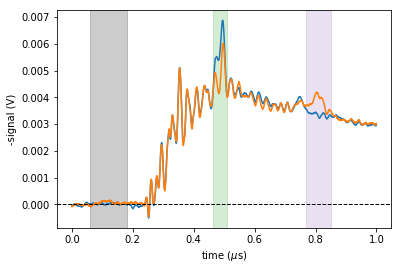

In [5]:
dat = scan.array('osc_0')
osc = scan.attrs('osc_0')

# plot
fig, ax = plt.subplots()

# data
dt = 1e6 * osc['dt']
xvals = np.arange(0, len(dat[0])*dt, dt)
yvals = -dat[0]
ax.plot(xvals, yvals - np.mean(yvals[:100]))
yvals = -dat[80]
ax.plot(xvals, yvals - np.mean(yvals[:100]))
ax.axhline(0, lw=1, c='k', ls='--')

# regions of interest
# background
t_bk = (0.06, 0.18)
ax.axvspan(*t_bk, color='k', alpha=0.2)
# signal 0
t_sig0 = (0.465, 0.510)
ax.axvspan(*t_sig0, color='C2', alpha=0.2)
# signal 1
t_sig1 = (0.77, 0.85)
ax.axvspan(*t_sig1, color='C4', alpha=0.2)

# format
ax.set_xlabel('time ($\mu$s)')
ax.set_ylabel('-signal (V)')

# output
plt.show()

Calculate the mean value of the scope data in the first time region using `mean()`.  This provides the background offset values.

In [6]:
# background
subset = tuple([slice(None), slice(*t_index(t_bk, dt))])
background = mean(scan.array('osc_0'), subset=subset)
background.columns = ['offset']

Subtract the background from each trace and then calculate the total value in the second and third regions using `total()`.  

The ratio between these is the final result.

In [7]:
# signal
bksub = np.subtract(scan.array('osc_0'), background.values)
subset = tuple([slice(None), slice(*t_index(t_sig0, dt))])
res0 = total(bksub, subset=subset)
res0.columns = [('total_0')]

subset = tuple([slice(None), slice(*t_index(t_sig1, dt))])
res1 = total(bksub, subset=subset)
res1.columns = [('total_1')]

# map result to microwave frequency
df = scan.df('analysis').join(res0).join(res1)
# combine the two sums
df['f2'] = (df['total_1'] / df['total_0'])
# normalise f and f2
df['f1'] = (df['f'] - df['f'].min()) / ( df['f'].max() -  df['f'].min())
df['f2'] = (df['f2'] - df['f2'].min()) / ( df['f2'].max() -  df['f2'].min())
df.head()

,var,w0,w1,a0,a1,a2,f,total_0,total_1,f2,f1
measurement,,,,,,,,,,,
0,32.0500,777.950119,786.992730,0.000499,-0.005882,-1.118270,-0.006381,-0.250957,-0.266740,0.118938,0.193245
1,32.0505,777.950119,786.992729,0.000458,-0.006048,-1.122989,-0.006506,-0.258617,-0.268857,0.054865,0.112717
2,32.0510,777.950120,786.992729,0.000443,-0.005974,-1.138911,-0.006417,-0.255175,-0.271211,0.118813,0.170390
3,32.0515,777.950119,786.992729,0.000860,-0.005568,-0.995466,-0.006428,-0.253729,-0.278458,0.214038,0.163247
4,32.0520,777.950119,786.992729,0.000522,-0.005977,-1.095825,-0.006499,-0.259907,-0.272130,0.075313,0.116918


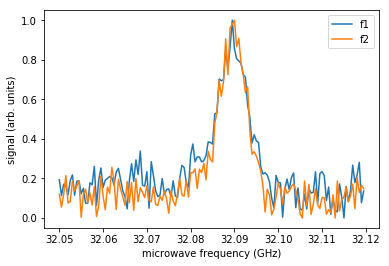

In [8]:
# plot
fig, ax = plt.subplots()
ax.plot(df['var'], df['f1'], label='f1')
ax.plot(df['var'], df['f2'], label='f2')
ax.set_xlabel("microwave frequency (GHz)")
ax.set_ylabel("signal (arb. units)")
ax.legend()
plt.show()

## Advanced processing
---

Using the `e11.process` functions as demonstrated above also works for `H5Data` datasets.

However, the functions can also be individually mapped to the datasets inside of each group using the class method `H5Data.apply()`, which indexes the result using the `squid`.  This makes it easy to keep track of the relationships between the processing results and the experimental settings (`VARS`).

### Vrange

Here, we are applying the `vrange` function to measure the vertical range of array data.

In [9]:
# load data
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
data = H5Data(fil)

In [10]:
rng, info = data.apply(vrange, data.squids, ['OSC_0'], info=True, name='vr')
rng.head()

100%|██████████| 6/6 [00:00<00:00, 123.15sq/s]


vr
squid measurement          
1     0            1.033028
      1            1.012191
      2            1.032403
      3            1.070328
      4            1.062143

In [11]:
rng.describe()

,vr
count,151.000000
mean,1.039718
std,0.015097
min,0.997321
25%,1.031731
50%,1.041619
75%,1.050006
max,1.083854


In [12]:
# information about the processing
info

{'func': 'vrange',
 'squids': array([1, 2, 3, 4, 5, 6]),
 'dataset': ['OSC_0'],
 'method': 'apply',
 'datetime': '2018-12-16 22:46:44',
 'cache': False}

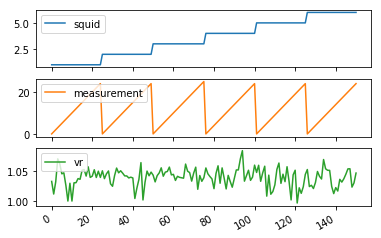

In [13]:
# plot
rng.reset_index().plot(subplots=True)

#output
plt.show()

### _apply()_ with multiple datasets

In [14]:
from e11.process import mean, mean_std

In [15]:
avg = data.apply(mean, data.squids, ['OSC_0', 'OSC_0'], keys=['av_A', 'av_B']).head()
avg.head()

100%|██████████| 6/6 [00:00<00:00, 134.68sq/s]


av_A      av_B
squid measurement                    
1     0            0.738350  0.738350
      1            0.738752  0.738752
      2            0.738586  0.738586
      3            0.738578  0.738578
      4            0.738438  0.738438

In [16]:
sta = data.apply(mean_std, data.squids, ['OSC_0', 'OSC_0'], keys=['A', 'B'])
sta.head()

100%|██████████| 6/6 [00:00<00:00, 58.94sq/s]


A                   B          
                       mean       std      mean       std
squid measurement                                        
1     0            0.738350  0.423929  0.738350  0.423929
      1            0.738752  0.423923  0.738752  0.423923
      2            0.738586  0.423920  0.738586  0.423920
      3            0.738578  0.423958  0.738578  0.423958
      4            0.738438  0.423983  0.738438  0.423983

### _apply()_ with lambda functions

The _apply()_ method accepts any function that returns either a _pd.Series()_ or a _pd.DataFrame()_.

In [17]:
mx = data.apply(lambda arr: pd.Series(np.max(arr, axis=1), name="max"), data.squids, 'OSC_0')
mx.head()

100%|██████████| 6/6 [00:00<00:00, 189.26sq/s]


squid   
1      0    1.035434
       1    1.015597
       2    1.035778
       3    1.072609
       4    1.064456
Name: max, dtype: float64

The input to the function must include kwargs if you call _apply()_ with any.  If you call _apply()_ with multiple datasets they are passed to the function as an unpacked list.

In [18]:
func = lambda *arr, **kwargs: pd.DataFrame(np.array([np.max(arr[0], axis=1), np.min(arr[1], axis=1)]).T, columns=kwargs["columns"])
mxs = data.apply(func, data.squids, ['OSC_0', 'OSC_0'], columns=["max_0", "min_1"])
mxs.head()

100%|██████████| 6/6 [00:00<00:00, 131.64sq/s]


max_0     min_1
squid                      
1     0  1.035434  0.002406
      1  1.015597  0.003406
      2  1.035778  0.003375
      3  1.072609  0.002281
      4  1.064456  0.002313